In [56]:
import transformers
from transformers import AutoImageProcessor, AutoModelForImageClassification
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import tqdm
import json
import scipy.stats as sps

In [2]:
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [3]:
vit_all_params_count = model.num_parameters()
vit_att_params_count = 768 * 768 * 3 * 12
print("Overall amount of parameters:", vit_all_params_count)
print("Attention weights parameters:", vit_att_params_count)
print("Attention weights share:     ", np.round(vit_att_params_count / vit_all_params_count, 3))

Overall amount of parameters: 86567656
Attention weights parameters: 21233664
Attention weights share:      0.245


In [4]:
weights_query_matrices = []
weights_key_matrices = []
weights_value_matrices = []

for i in tqdm.tqdm(range(12)):
    weights_query_matrices.append(model.vit.encoder.layer[i].attention.attention.query.weight.detach().numpy())
    weights_key_matrices.append(model.vit.encoder.layer[i].attention.attention.key.weight.detach().numpy())
    weights_value_matrices.append(model.vit.encoder.layer[i].attention.attention.value.weight.detach().numpy())

100%|██████████| 12/12 [00:00<00:00, 12703.60it/s]


In [5]:
weights_query_variance_ratio = []
weights_key_variance_ratio = []
weights_value_variance_ratio = []

for i in tqdm.tqdm(range(12)):
    weights = weights_query_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_query_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_key_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_key_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

    weights = weights_value_matrices[i]
    U, Sigma, V = np.linalg.svd(weights)
    weights_value_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))

100%|██████████| 12/12 [00:19<00:00,  1.58s/it]


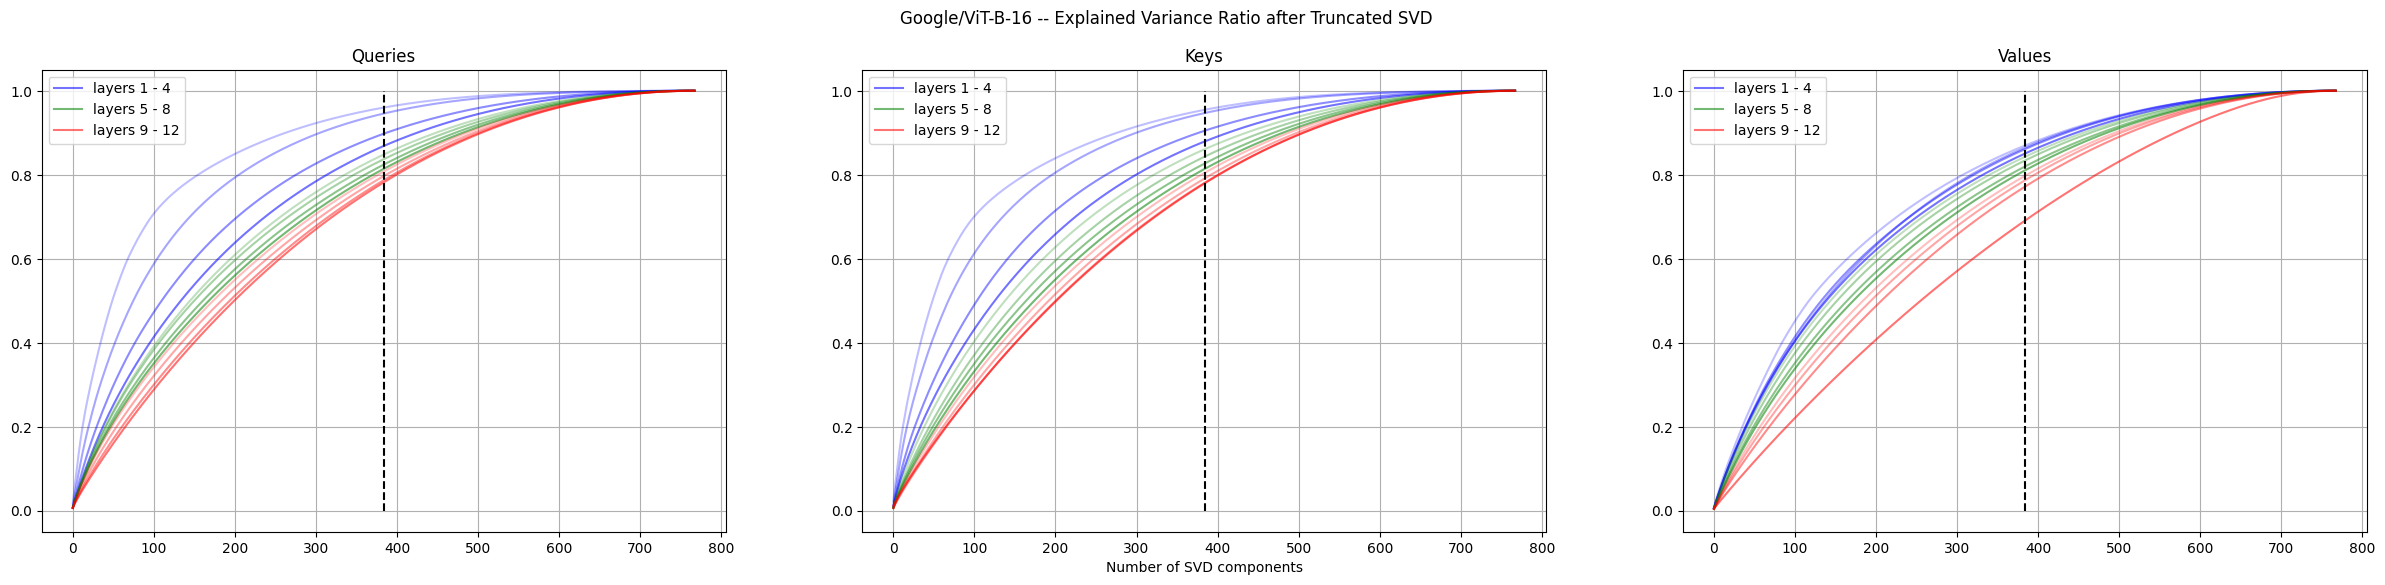

In [6]:
colors = ['blue', 'green', 'red']
titles = ['Queries', 'Keys', 'Values']

weights_variance_ratio = [weights_query_variance_ratio, weights_key_variance_ratio, weights_value_variance_ratio]

plt.figure(figsize=(30, 6))

for j in range(3):
    plt.subplot(1, 3, j + 1)
    for i in range(12):
        if i % 4 == 3:
            layer_num = i // 4
            plt.plot(weights_variance_ratio[j][i], alpha=0.25 + (i % 4) * 0.1, color=colors[i // 4], label=f"layers {4 * layer_num + 1} - {4 * layer_num + 4}")
        else:
            plt.plot(weights_variance_ratio[j][i], alpha=0.25 + (i % 4) * 0.1, color=colors[i // 4])

    plt.vlines(len(weights_variance_ratio[0][0]) // 2, ymin=0, ymax=1, linestyle='--', color='black')

    plt.title(titles[j])
    plt.legend()
    plt.grid()

    if j == 1:
        plt.xlabel('Number of SVD components')

plt.suptitle('Google/ViT-B-16 -- Explained Variance Ratio after Truncated SVD')

plt.show()

### Allocation Aware SVD

In [7]:
ImageNetValidationTransformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225],   # ImageNet std
    ),
])

ImageNetValidationSet = ImageFolder(root='../data_modified', transform=ImageNetValidationTransformation)
ImageNetValidationDataLoader = DataLoader(ImageNetValidationSet, batch_size=64, shuffle=True)

In [8]:
def make_forward_pre_hook(module_name: str, statistics_dict: dict[str, list[torch.Tensor]]):
    def forward_pre_hook(module: torch.nn.Module, input):
        x = input[0]
        if module_name not in statistics_dict:
            statistics_dict[module_name] = []

        statistics_dict[module_name].append(x.detach().clone().cpu().numpy())

    return forward_pre_hook

model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

handlers = []

statistics_dict = dict()

for i in range(12):
    handler = model.vit.encoder.layer[i].attention.attention.query.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/query', statistics_dict)
    )
    handlers.append(handler)

    handler = model.vit.encoder.layer[i].attention.attention.key.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/key', statistics_dict)
    )
    handlers.append(handler)

    handler = model.vit.encoder.layer[i].attention.attention.value.register_forward_pre_hook(
        make_forward_pre_hook(f'{i}/value', statistics_dict)
    )
    handlers.append(handler)

In [9]:
model.eval()

device = torch.device('cuda:3')

model = model.to(device)

for iter, (batch_x, batch_y) in enumerate(ImageNetValidationDataLoader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_output = model(batch_x)
    print(iter, len(statistics_dict['0/value']))

    if iter == 9:
        break

0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10


In [10]:
statistics_dict_concat = dict()

for i in range(12):
    for key in ['key', 'value', 'query']:
        statistics_dict_concat[f'{i}/{key}'] = np.concatenate(statistics_dict[f'{i}/{key}'], axis=0)

statistics_dict_concat['0/key'].shape

(640, 197, 768)

In [11]:
for handler in handlers:
    handler.remove()

In [12]:
for i in range(12):
    for key in ['key', 'value', 'query']:
        statistics_dict_concat[f'{i}/{key}'] = np.transpose(statistics_dict_concat[f'{i}/{key}'], (2, 0, 1)).reshape((768, -1))

statistics_dict_concat['0/key'].shape

(768, 126080)

100%|██████████| 12/12 [00:03<00:00,  3.75it/s]


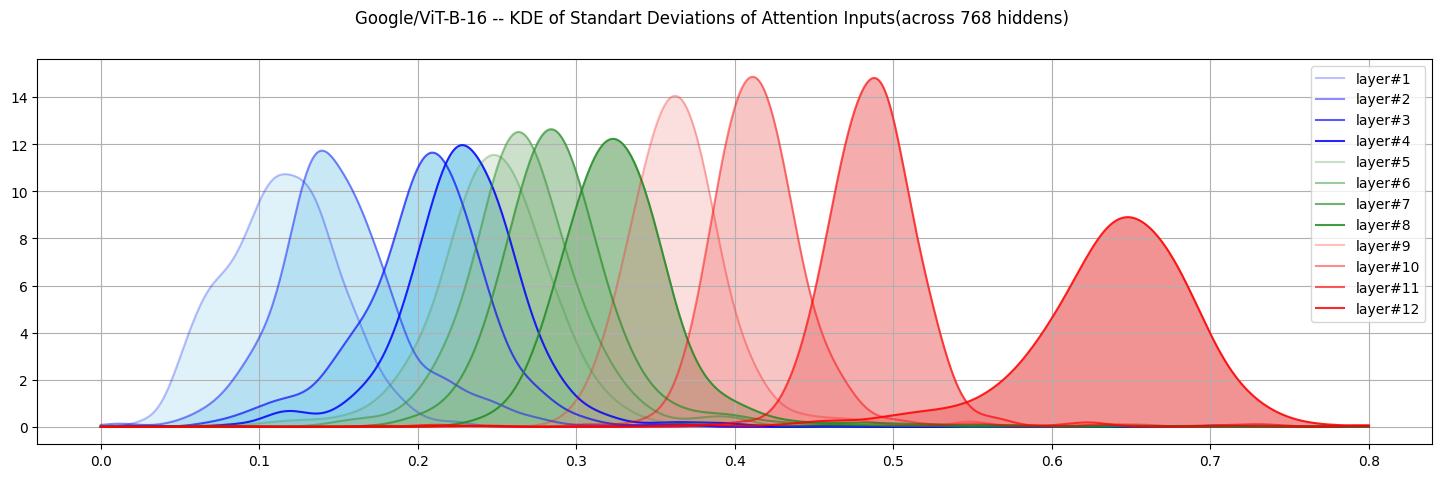

In [ ]:
plt.figure(figsize=(18, 5))

colors = ['blue', 'forestgreen', 'red']
background_colors = ['skyblue', 'darkseagreen', 'lightcoral']

for layer in tqdm.tqdm(range(12)):
    values = np.std(statistics_dict_concat[f'{layer}/value'], axis=1)
    kde = sps.gaussian_kde(values)
    grid = np.linspace(0, 0.8, 1000)
    kde_grid = kde(grid)
    plt.plot(grid, kde_grid, color=colors[layer // 4], alpha=0.25 + 0.2 * (layer % 4), label=f'layer#{layer + 1}')
    plt.fill_between(grid, np.zeros_like(grid), kde_grid, color=background_colors[layer // 4], alpha=0.25 + 0.2 * (layer % 4))

plt.grid()
plt.legend()
plt.suptitle('Google/ViT-B-16 -- KDE of Standart Deviations of Attention Inputs(across 768 hiddens)')
plt.show()

100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


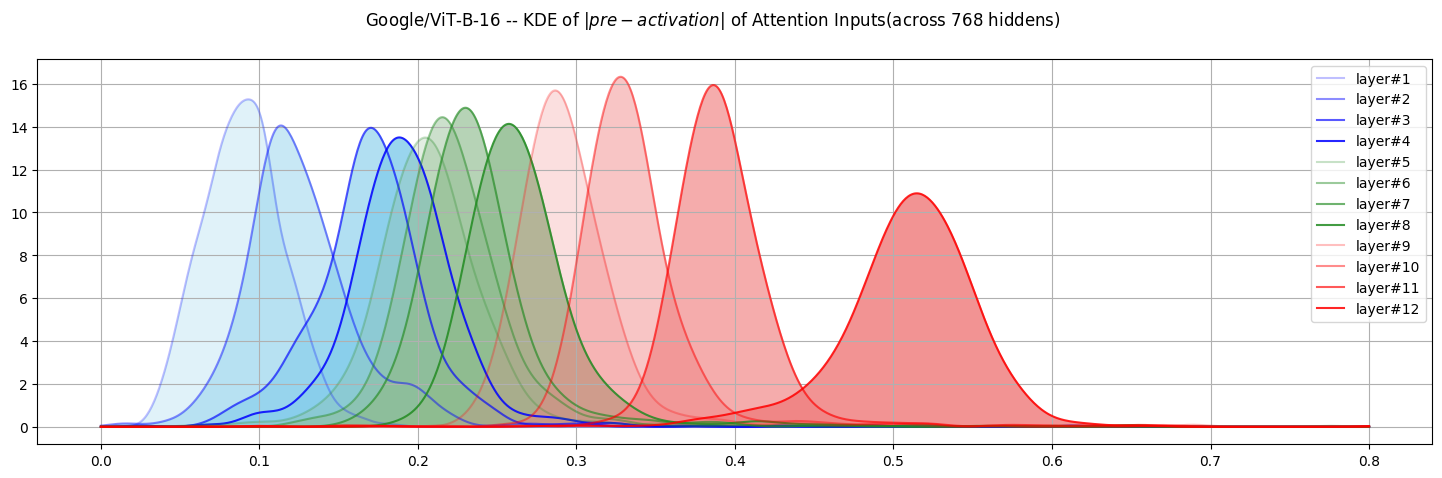

In [77]:
plt.figure(figsize=(18, 5))

colors = ['blue', 'forestgreen', 'red']
background_colors = ['skyblue', 'darkseagreen', 'lightcoral']

for layer in tqdm.tqdm(range(12)):
    values = np.mean(np.abs(statistics_dict_concat[f'{layer}/value']), axis=1)
    kde = sps.gaussian_kde(values)
    grid = np.linspace(0, 0.8, 1000)
    kde_grid = kde(grid)
    plt.plot(grid, kde_grid, color=colors[layer // 4], alpha=0.25 + 0.2 * (layer % 4), label=f'layer#{layer + 1}')
    plt.fill_between(grid, np.zeros_like(grid), kde_grid, color=background_colors[layer // 4], alpha=0.25 + 0.2 * (layer % 4))

plt.grid()
plt.legend()
plt.suptitle(r'Google/ViT-B-16 -- KDE of $|pre-activation|$ of Attention Inputs(across 768 hiddens)')
plt.show()

In [ ]:
activation_aware_weights_query_variance_ratio = []
activation_aware_weights_key_variance_ratio = []
activation_aware_weights_value_variance_ratio = []


for i in tqdm.tqdm(range(12)):
    weights_times_preactivations = weights_query_matrices[i] @ statistics_dict_concat[f'{i}/query']
    U, Sigma, V = np.linalg.svd(weights_times_preactivations)
    activation_aware_weights_query_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))
    print(f'Query#{i}')

    weights_times_preactivations = weights_key_matrices[i] @ statistics_dict_concat[f'{i}/key']
    U, Sigma, V = np.linalg.svd(weights_times_preactivations)
    activation_aware_weights_key_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))
    print(f'Key#{i}')

    weights_times_preactivations = weights_value_matrices[i] @ statistics_dict_concat[f'{i}/value']
    U, Sigma, V = np.linalg.svd(weights_times_preactivations)
    activation_aware_weights_value_variance_ratio.append(np.cumsum(Sigma) / np.sum(Sigma))
    print(f'Value#{i}')

  0%|          | 0/12 [00:00<?, ?it/s]

IndexError: list index out of range

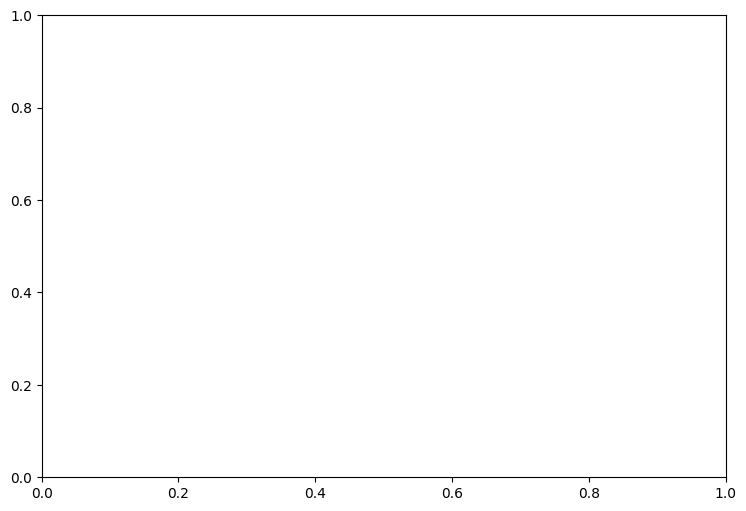

In [15]:
activation_aware_weights_variance_ratio = [
    activation_aware_weights_query_variance_ratio,
    activation_aware_weights_key_variance_ratio,
    activation_aware_weights_value_variance_ratio
]

plt.figure(figsize=(30, 6))

for j in range(3):
    plt.subplot(1, 3, j + 1)
    for i in range(12):
        if i % 4 == 3:
            layer_num = i // 4
            plt.plot(activation_aware_weights_variance_ratio[j][i], alpha=0.25 + (i % 4) * 0.1, color=colors[i // 4], label=f"layers {4 * layer_num + 1} - {4 * layer_num + 4}")
        else:
            plt.plot(activation_aware_weights_variance_ratio[j][i], alpha=0.25 + (i % 4) * 0.1, color=colors[i // 4])

    plt.vlines(len(activation_aware_weights_variance_ratio[0][0]) // 2, ymin=0, ymax=1, linestyle='--', color='black')

    plt.title(titles[j])
    plt.legend()
    plt.grid()

    if j == 1:
        plt.xlabel('Number of SVD components')

plt.suptitle('Google/ViT-B-16 -- Explained Variance Ratio after Truncated SVD for WX')

plt.show()

### SVD and accuracy degradation

In [8]:
class TruncatedSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: np.ndarray, bias: np.ndarray, device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = np.linalg.svd(weight, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = np.diag(Sigma[:min(rank, max_rank)])
        U = U[:, :min(rank, max_rank)] @ SigmaDiag
        V = V[:min(rank, max_rank), :]

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(torch.tensor(U, dtype=torch.float32))
        self.U.bias.data.copy_(torch.tensor(bias, dtype=torch.float32))
        self.V.weight.data.copy_(torch.tensor(V, dtype=torch.float32))
        self.U = self.U.to(device)
        self.V = self.V.to(device)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'


In [ ]:
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model = model.to(device)
model.eval()

accuracy_list = []
accuracy_metrics = Accuracy(task='multiclass', num_classes=1000).to(device)

for (batch_x, batch_y) in tqdm.tqdm(ImageNetValidationDataLoader):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    batch_y_pred_logits = model(batch_x)
    batch_y_pred_values = torch.argmax(batch_y_pred_logits.logits, dim=1)

    acc = accuracy_metrics(batch_y, batch_y_pred_values)

    accuracy_list.append(acc.item())

  1%|          | 9/782 [00:07<10:25,  1.24it/s]


KeyboardInterrupt: 

In [55]:
original_accuracy = np.mean(accuracy_list)
print("ViT-B-16-224 accuracy:", original_accuracy)

ViT-B-16-224 accuracy: 0.7567535166240409


In [9]:
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

def MakeModifiedModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device,
) -> nn.Module:
    model_modified = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    for i in range(min(max_layer, all_layers)):
        model_modified.vit.encoder.layer[i].attention.attention.query = TruncatedSVDLinear(
            rank=max_rank,
            weight=weights_query_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.query.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

        model_modified.vit.encoder.layer[i].attention.attention.key = TruncatedSVDLinear(
            rank=max_rank,
            weight=weights_key_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.key.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

        model_modified.vit.encoder.layer[i].attention.attention.value = TruncatedSVDLinear(
            rank=max_rank,
            weight=weights_value_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.value.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

    return model_modified.to(device)

def EvaluateModel(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    rank: int,
) -> dict[str, int | float]:
    model = model.to(device)
    model.eval()

    accuracy_metrics = []
    accuracy_function = Accuracy(task="multiclass", num_classes=1000).to(device)

    for (batch_x, batch_y) in tqdm.tqdm(dataloader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        batch_y_pred_logits = model(batch_x)
        batch_y_pred_values = torch.argmax(batch_y_pred_logits.logits, dim=1)

        acc = accuracy_function(batch_y, batch_y_pred_values)
        accuracy_metrics.append(acc.item())

    with torch.no_grad():
        value = np.mean(accuracy_metrics)

    return {"accuracy": value, "model": model.num_parameters(), "rank": rank}

In [10]:
rank = 192
ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=128, shuffle=True)
AccuracyResults = []

In [ ]:
rank = 192
device = torch.device('cuda:6')

ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=128, shuffle=True)
AccuracyResults = []

for i in range(0, 12):
    model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    model_modified = MakeModifiedModel(model, max_rank=rank, max_layer=i + 1, all_layers=12, device=device)
    model_parameters = EvaluateModel(model_modified, ImageNetValidationHugeDataLoader, device, rank)
    AccuracyResults.append(model_parameters)
    with open(f'accuracy_scores/accuracy-results-{i+1}.json', 'w') as json_file:
        json.dump(model_parameters, json_file, indent=4)
    print(f'#{i + 1} finished')


100%|██████████| 391/391 [07:18<00:00,  1.12s/it]

#9 finished


In [46]:
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")

with open(f'accuracy_scores/accuracy-results-{0}.json', 'w') as json_file:
        model_parameters = {
                "accuracy": 0.7567535166240409,
                "model": model.num_parameters(),
                "rank": 192,
        }
        json.dump(model_parameters, json_file, indent=4)


In [47]:
accuracy_scores = []
accuracy_scores_96 = []
parameters_ratio = []
parameters_ratio_96 = []

accuracy_scores_adaptive = []
accuracy_scores_adaptive_96 = []
parameters_ratio_adaptive = []
parameters_ratio_adaptive_96 = []

accuracy_scores_96.append(model_parameters['accuracy'])
parameters_ratio_96.append(model_parameters['model'] / model.num_parameters())
accuracy_scores_adaptive.append(model_parameters['accuracy'])
parameters_ratio_adaptive.append(model_parameters['model'] / model.num_parameters())
accuracy_scores_adaptive_96.append(model_parameters['accuracy'])
parameters_ratio_adaptive_96.append(model_parameters['model'] / model.num_parameters())

for i in range(0, 13):
    with open(f'accuracy_scores/accuracy-results-{i}.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores.append(model_parameters['accuracy'])
        parameters_ratio.append(model_parameters['model'] / model.num_parameters())
    if i == 0:
        continue
    with open(f'accuracy_scores/accuracy-results-{i}-96.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores_96.append(model_parameters['accuracy'])
        parameters_ratio_96.append(model_parameters['model'] / model.num_parameters())
    with open(f'accuracy_scores/accuracy-results-adaptive-{i}-192.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores_adaptive.append(model_parameters['accuracy'])
        parameters_ratio_adaptive.append(model_parameters['model'] / model.num_parameters())
    with open(f'accuracy_scores/accuracy-results-adaptive-{i}-96.json', 'r') as file:
        model_parameters = json.load(file)
        accuracy_scores_adaptive_96.append(model_parameters['accuracy'])
        parameters_ratio_adaptive_96.append(model_parameters['model'] / model.num_parameters())


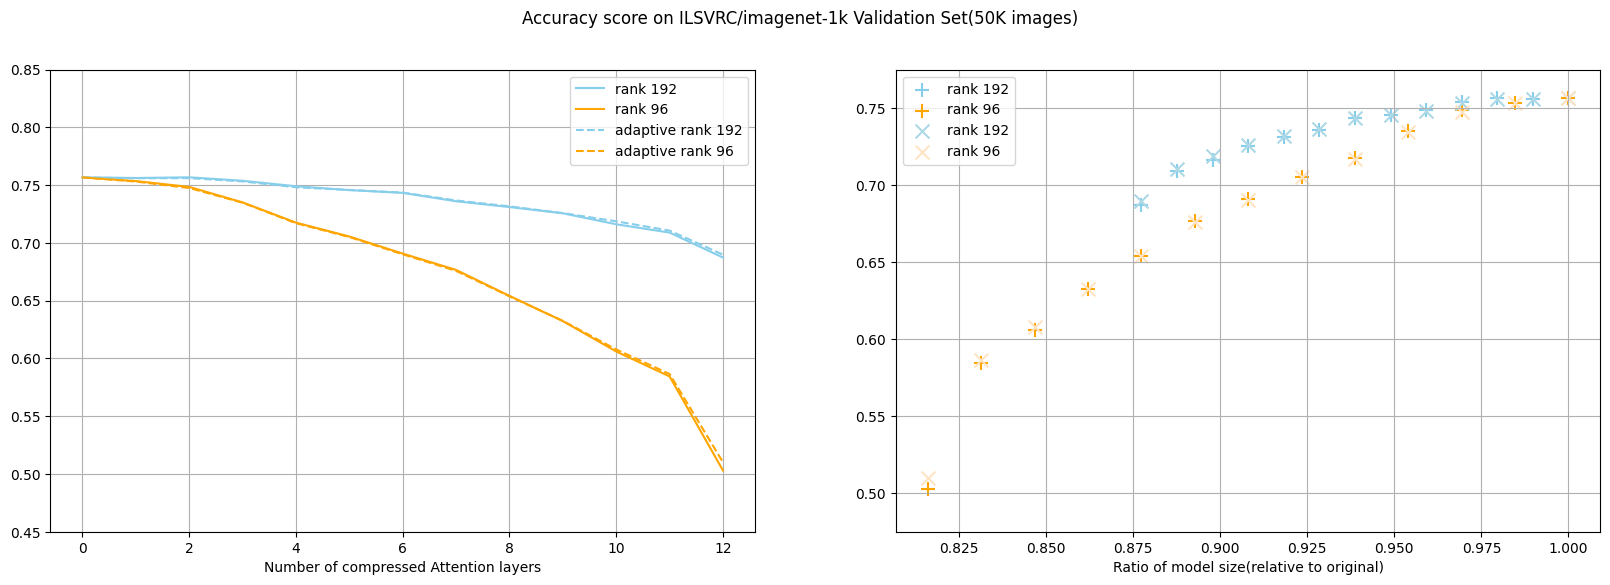

In [ ]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(np.arange(13), accuracy_scores, color='skyblue', label='rank 192')
plt.plot(np.arange(13), accuracy_scores_96, color='orange', label='rank 96')
plt.plot(np.arange(13), accuracy_scores_adaptive, color='skyblue', label='adaptive rank 192', linestyle='--')
plt.plot(np.arange(13), accuracy_scores_adaptive_96, color='orange', label='adaptive rank 96', linestyle='--')
plt.xlabel('Number of compressed Attention layers')
plt.ylim((0.45, 0.85))
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(parameters_ratio, accuracy_scores, marker='+', color='skyblue', s=100, label='rank 192')
plt.scatter(parameters_ratio_96, accuracy_scores_96, marker='+', color='orange', s=100, label='rank 96')
plt.scatter(parameters_ratio_adaptive, accuracy_scores_adaptive, marker='x', color='lightblue', s=100, label='rank 192')
plt.scatter(parameters_ratio_adaptive_96, accuracy_scores_adaptive_96, marker='x', color='bisque', s=100, label='rank 96')
plt.xlabel('Ratio of model size(relative to original)')
plt.ylim((0.475, 0.775))
plt.legend()
plt.grid()

plt.suptitle('Accuracy score on ILSVRC/imagenet-1k Validation Set(50K images)')
plt.show()

In [50]:
rank = 96
device = torch.device('cuda:3')

ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=96, shuffle=True)
AccuracyResults = []

for i in range(1, 13):
    model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    model_modified = MakeModifiedModel(model, max_rank=rank, max_layer=i, all_layers=12, device=device)
    model_parameters = EvaluateModel(model_modified, ImageNetValidationHugeDataLoader, device, rank)
    AccuracyResults.append(model_parameters)
    with open(f'accuracy_scores/accuracy-results-{i}-{rank}.json', 'w') as json_file:
        json.dump(model_parameters, json_file, indent=4)
    print(f'#{i} finished')

100%|██████████| 521/521 [06:40<00:00,  1.30it/s]


#1 finished


100%|██████████| 521/521 [08:51<00:00,  1.02s/it]


#2 finished


100%|██████████| 521/521 [15:02<00:00,  1.73s/it]


#3 finished


100%|██████████| 521/521 [06:22<00:00,  1.36it/s]


#4 finished


100%|██████████| 521/521 [06:07<00:00,  1.42it/s]


#5 finished


100%|██████████| 521/521 [06:50<00:00,  1.27it/s]


#6 finished


100%|██████████| 521/521 [06:26<00:00,  1.35it/s]


#7 finished


100%|██████████| 521/521 [06:05<00:00,  1.43it/s]


#8 finished


100%|██████████| 521/521 [05:59<00:00,  1.45it/s]


#9 finished


100%|██████████| 521/521 [05:59<00:00,  1.45it/s]


#10 finished


100%|██████████| 521/521 [05:55<00:00,  1.47it/s]


#11 finished


100%|██████████| 521/521 [05:50<00:00,  1.48it/s]

#12 finished


In [11]:
class TruncatedAdaptiveSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: np.ndarray, bias: np.ndarray, precondtioner: np.ndarray, device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = np.linalg.svd(weight @ precondtioner, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = np.diag(Sigma[:min(rank, max_rank)])
        U = U[:, :min(rank, max_rank)] @ SigmaDiag
        V = V[:min(rank, max_rank), :] @ np.linalg.inv(precondtioner)

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(torch.tensor(U, dtype=torch.float32))
        self.U.bias.data.copy_(torch.tensor(bias, dtype=torch.float32))
        self.V.weight.data.copy_(torch.tensor(V, dtype=torch.float32))
        self.U = self.U.to(device)
        self.V = self.V.to(device)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [12]:
def MakeAdaptiveModifiedModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device,
) -> nn.Module:
    model_modified = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    for i in range(min(max_layer, all_layers)):
        preconditioner = np.mean(np.abs(statistics_dict_concat[f'{i}/query'])**2, axis=1)**0.5
        #print(np.min(preconditioner), np.argmin(preconditioner))
        preconditioner = np.diag(preconditioner)
        model_modified.vit.encoder.layer[i].attention.attention.query = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=weights_query_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.query.bias.clone().detach().cpu().numpy(),
            precondtioner=preconditioner,
            device=model_modified.device,
        )

        preconditioner = np.mean(np.abs(statistics_dict_concat[f'{i}/key'])**2, axis=1)**0.5
        #print(np.min(preconditioner))
        preconditioner = np.diag(preconditioner)
        model_modified.vit.encoder.layer[i].attention.attention.key = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=weights_key_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.key.bias.clone().detach().cpu().numpy(),
            precondtioner=preconditioner,
            device=model_modified.device,
        )

        preconditioner = np.mean(np.abs(statistics_dict_concat[f'{i}/value'])**2, axis=1)**0.5
        #print(np.min(preconditioner))
        preconditioner = np.diag(preconditioner)
        model_modified.vit.encoder.layer[i].attention.attention.value = TruncatedAdaptiveSVDLinear(
            rank=max_rank,
            weight=weights_value_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.value.bias.clone().detach().cpu().numpy(),
            precondtioner=preconditioner,
            device=model_modified.device,
        )

    return model_modified.to(device)

In [50]:
device = torch.device('cuda:6')
rank = 192

ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=96, shuffle=True)
AccuracyResults = []

for i in range(1, 13):
    model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    model_modified = MakeAdaptiveModifiedModel(model, max_rank=rank, max_layer=i, all_layers=12, device=device)
    model_parameters = EvaluateModel(model_modified, ImageNetValidationHugeDataLoader, device, rank)
    AccuracyResults.append(model_parameters)
    with open(f'accuracy_scores/accuracy-results-adaptive-changed{i}-{rank}.json', 'w') as json_file:
        json.dump(model_parameters, json_file, indent=4)
    print(f'#{i} finished')

100%|██████████| 521/521 [06:35<00:00,  1.32it/s]


#1 finished


100%|██████████| 521/521 [06:26<00:00,  1.35it/s]


#2 finished


100%|██████████| 521/521 [06:30<00:00,  1.33it/s]


#3 finished


100%|██████████| 521/521 [06:35<00:00,  1.32it/s]


#4 finished


100%|██████████| 521/521 [06:35<00:00,  1.32it/s]


#5 finished


100%|██████████| 521/521 [06:38<00:00,  1.31it/s]


#6 finished


100%|██████████| 521/521 [06:48<00:00,  1.28it/s]


#7 finished


100%|██████████| 521/521 [06:39<00:00,  1.30it/s]


#8 finished


100%|██████████| 521/521 [06:46<00:00,  1.28it/s]


#9 finished


100%|██████████| 521/521 [06:45<00:00,  1.29it/s]


#10 finished


100%|██████████| 521/521 [07:30<00:00,  1.16it/s]


#11 finished


100%|██████████| 521/521 [08:15<00:00,  1.05it/s]

#12 finished


In [ ]:
device = torch.device('cuda:1')
rank = 96

ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=96, shuffle=True)
AccuracyResults = []

for i in range(1, 13):
    model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    model_modified = MakeAdaptiveModifiedModel(model, max_rank=rank, max_layer=i, all_layers=12, device=device)
    model_parameters = EvaluateModel(model_modified, ImageNetValidationHugeDataLoader, device, rank)
    AccuracyResults.append(model_parameters)
    with open(f'accuracy_scores/accuracy-results-adaptive-{i}-{rank}.json', 'w') as json_file:
        json.dump(model_parameters, json_file, indent=4)
    print(f'#{i} finished')

100%|██████████| 521/521 [06:29<00:00,  1.34it/s]


#9 finished


100%|██████████| 521/521 [06:20<00:00,  1.37it/s]


#10 finished


100%|██████████| 521/521 [06:22<00:00,  1.36it/s]


#11 finished


100%|██████████| 521/521 [06:12<00:00,  1.40it/s]

#12 finished


In [13]:
class TruncatedRescaledSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: np.ndarray, bias: np.ndarray, device: torch.device = torch.device('cpu')):
        super().__init__()
        U, Sigma, V = np.linalg.svd(weight, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = np.diag(Sigma[:min(rank, max_rank)])
        RescaleCoeff = np.sum(Sigma) / np.trace(SigmaDiag)
        U = U[:, :min(rank, max_rank)] @ SigmaDiag * RescaleCoeff
        V = V[:min(rank, max_rank), :]

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(torch.tensor(U, dtype=torch.float32))
        self.U.bias.data.copy_(torch.tensor(bias * RescaleCoeff, dtype=torch.float32))
        self.V.weight.data.copy_(torch.tensor(V, dtype=torch.float32))
        self.U = self.U.to(device)
        self.V = self.V.to(device)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [ ]:
class TruncatedRescaledBiasSVDLinear(nn.Module):
    def __init__(self, rank: int, weight: np.ndarray, bias: np.ndarray, device: torch.device = torch.device('cpu')):
        super().__init__()
        weight_matrix_bias = np.concat((weight, np.expand_dims(bias, 1)), axis=1)
        U, Sigma, V = np.linalg.svd(weight_matrix_bias, full_matrices=False)
        max_rank = len(Sigma)
        SigmaDiag = np.diag(Sigma[:min(rank, max_rank)])
        RescaleCoeff = np.sum(Sigma) / np.trace(SigmaDiag)
        U = U[:, :min(rank, max_rank)] @ SigmaDiag * RescaleCoeff
        V = V[:min(rank, max_rank), :]

        self.U = nn.Linear(in_features=min(rank, max_rank), out_features=weight.shape[0], bias=True)
        self.V = nn.Linear(in_features=weight.shape[1], out_features=min(rank, max_rank), bias=False)
        self.U.weight.data.copy_(torch.tensor(U, dtype=torch.float32))
        self.U.bias.data.copy_(torch.tensor(bias * RescaleCoeff, dtype=torch.float32))
        self.V.weight.data.copy_(torch.tensor(V, dtype=torch.float32))
        self.U = self.U.to(device)
        self.V = self.V.to(device)

    def forward(self, input):
        return self.U(self.V(input))

    def __repr__(self):
        return f'(\n\t(U): {self.U.__repr__()}\n\t(V): {self.V.__repr__()}\n)'

In [15]:
def MakeScaledModifiedModel(
    model: nn.Module,
    max_rank: int,
    max_layer: int,
    all_layers: int,
    device: torch.device,
) -> nn.Module:
    model_modified = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    for i in range(min(max_layer, all_layers)):
        model_modified.vit.encoder.layer[i].attention.attention.query = TruncatedRescaledSVDLinear(
            rank=max_rank,
            weight=weights_query_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.query.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

        model_modified.vit.encoder.layer[i].attention.attention.key = TruncatedRescaledSVDLinear(
            rank=max_rank,
            weight=weights_key_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.key.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

        model_modified.vit.encoder.layer[i].attention.attention.value = TruncatedRescaledSVDLinear(
            rank=max_rank,
            weight=weights_value_matrices[i],
            bias=model.vit.encoder.layer[i].attention.attention.value.bias.clone().detach().cpu().numpy(),
            device=model_modified.device,
        )

    return model_modified.to(device)

In [16]:
rank = 192
device = torch.device('cuda:3')

ImageNetValidationHugeDataLoader = DataLoader(ImageNetValidationSet, batch_size=96, shuffle=True)
AccuracyResults = []

for i in range(1, 13):
    model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
    model_modified = MakeScaledModifiedModel(model, max_rank=rank, max_layer=i, all_layers=12, device=device)
    model_parameters = EvaluateModel(model_modified, ImageNetValidationHugeDataLoader, device, rank)
    AccuracyResults.append(model_parameters)
    with open(f'accuracy_scores/accuracy-results-rescaled-{i}-{rank}.json', 'w') as json_file:
        json.dump(model_parameters, json_file, indent=4)
    print(f'#{i} finished')

100%|██████████| 521/521 [07:03<00:00,  1.23it/s]


#1 finished


100%|██████████| 521/521 [07:02<00:00,  1.23it/s]


#2 finished


100%|██████████| 521/521 [07:10<00:00,  1.21it/s]


#3 finished


100%|██████████| 521/521 [07:14<00:00,  1.20it/s]


#4 finished


100%|██████████| 521/521 [07:02<00:00,  1.23it/s]


#5 finished


100%|██████████| 521/521 [06:59<00:00,  1.24it/s]


#6 finished


100%|██████████| 521/521 [07:05<00:00,  1.22it/s]


#7 finished


100%|██████████| 521/521 [07:33<00:00,  1.15it/s]


#8 finished


100%|██████████| 521/521 [08:02<00:00,  1.08it/s]


#9 finished


100%|██████████| 521/521 [07:34<00:00,  1.15it/s]


#10 finished


100%|██████████| 521/521 [07:34<00:00,  1.15it/s]


#11 finished


100%|██████████| 521/521 [07:41<00:00,  1.13it/s]

#12 finished
